# **7. Whole Slide Image Classification Using PyTorch and TIAToolbox**

TIAToolbox의 도움을 받아 PyTorch 딥러닝 모델을 사용해 WSI(Whole Slide Image)를 분류하는 방법을 설명함

WSI 는 수술이나 생검을 통해 채취한 인체 조직 샘플을 특수 스캐너로 스캔한 이미지

암 같은 질병의 미세한 수준의 진행양상을 이해하기 위해 함

# WSI 어려운 이유

WSI는 어마어마하게 큰 이미지임 100,000 x 100,000 픽셀 정도의 해상도를 가지고 각 픽셀은 슬라이드 상의 0.25 x 0.25 마이크론 정도를 나타냄 그래서

1. 로딩과 처리 속도가 느리고
2. 한 연구에 수백 ~ 수천 장의 WSI 가 포함되기도 하며
3. 기존의 이미지 처리 방식으로는 대응이 어려움

# TAIToolbox 가 도와주는 부분

조직 슬라이드의 로딩과 분석을 빠르고 효율적으로 자동화할 수 있음

WSI 는 일반적으로 여러 해상도를 가진 피라미드 구조로 저장됨

레벨 0 : 가장 높은 배율의 원본 이미지 (가장 자세)

상위 레벨 : 점점 낮은 해상도로 저장된 이미지 (빨리 보기)

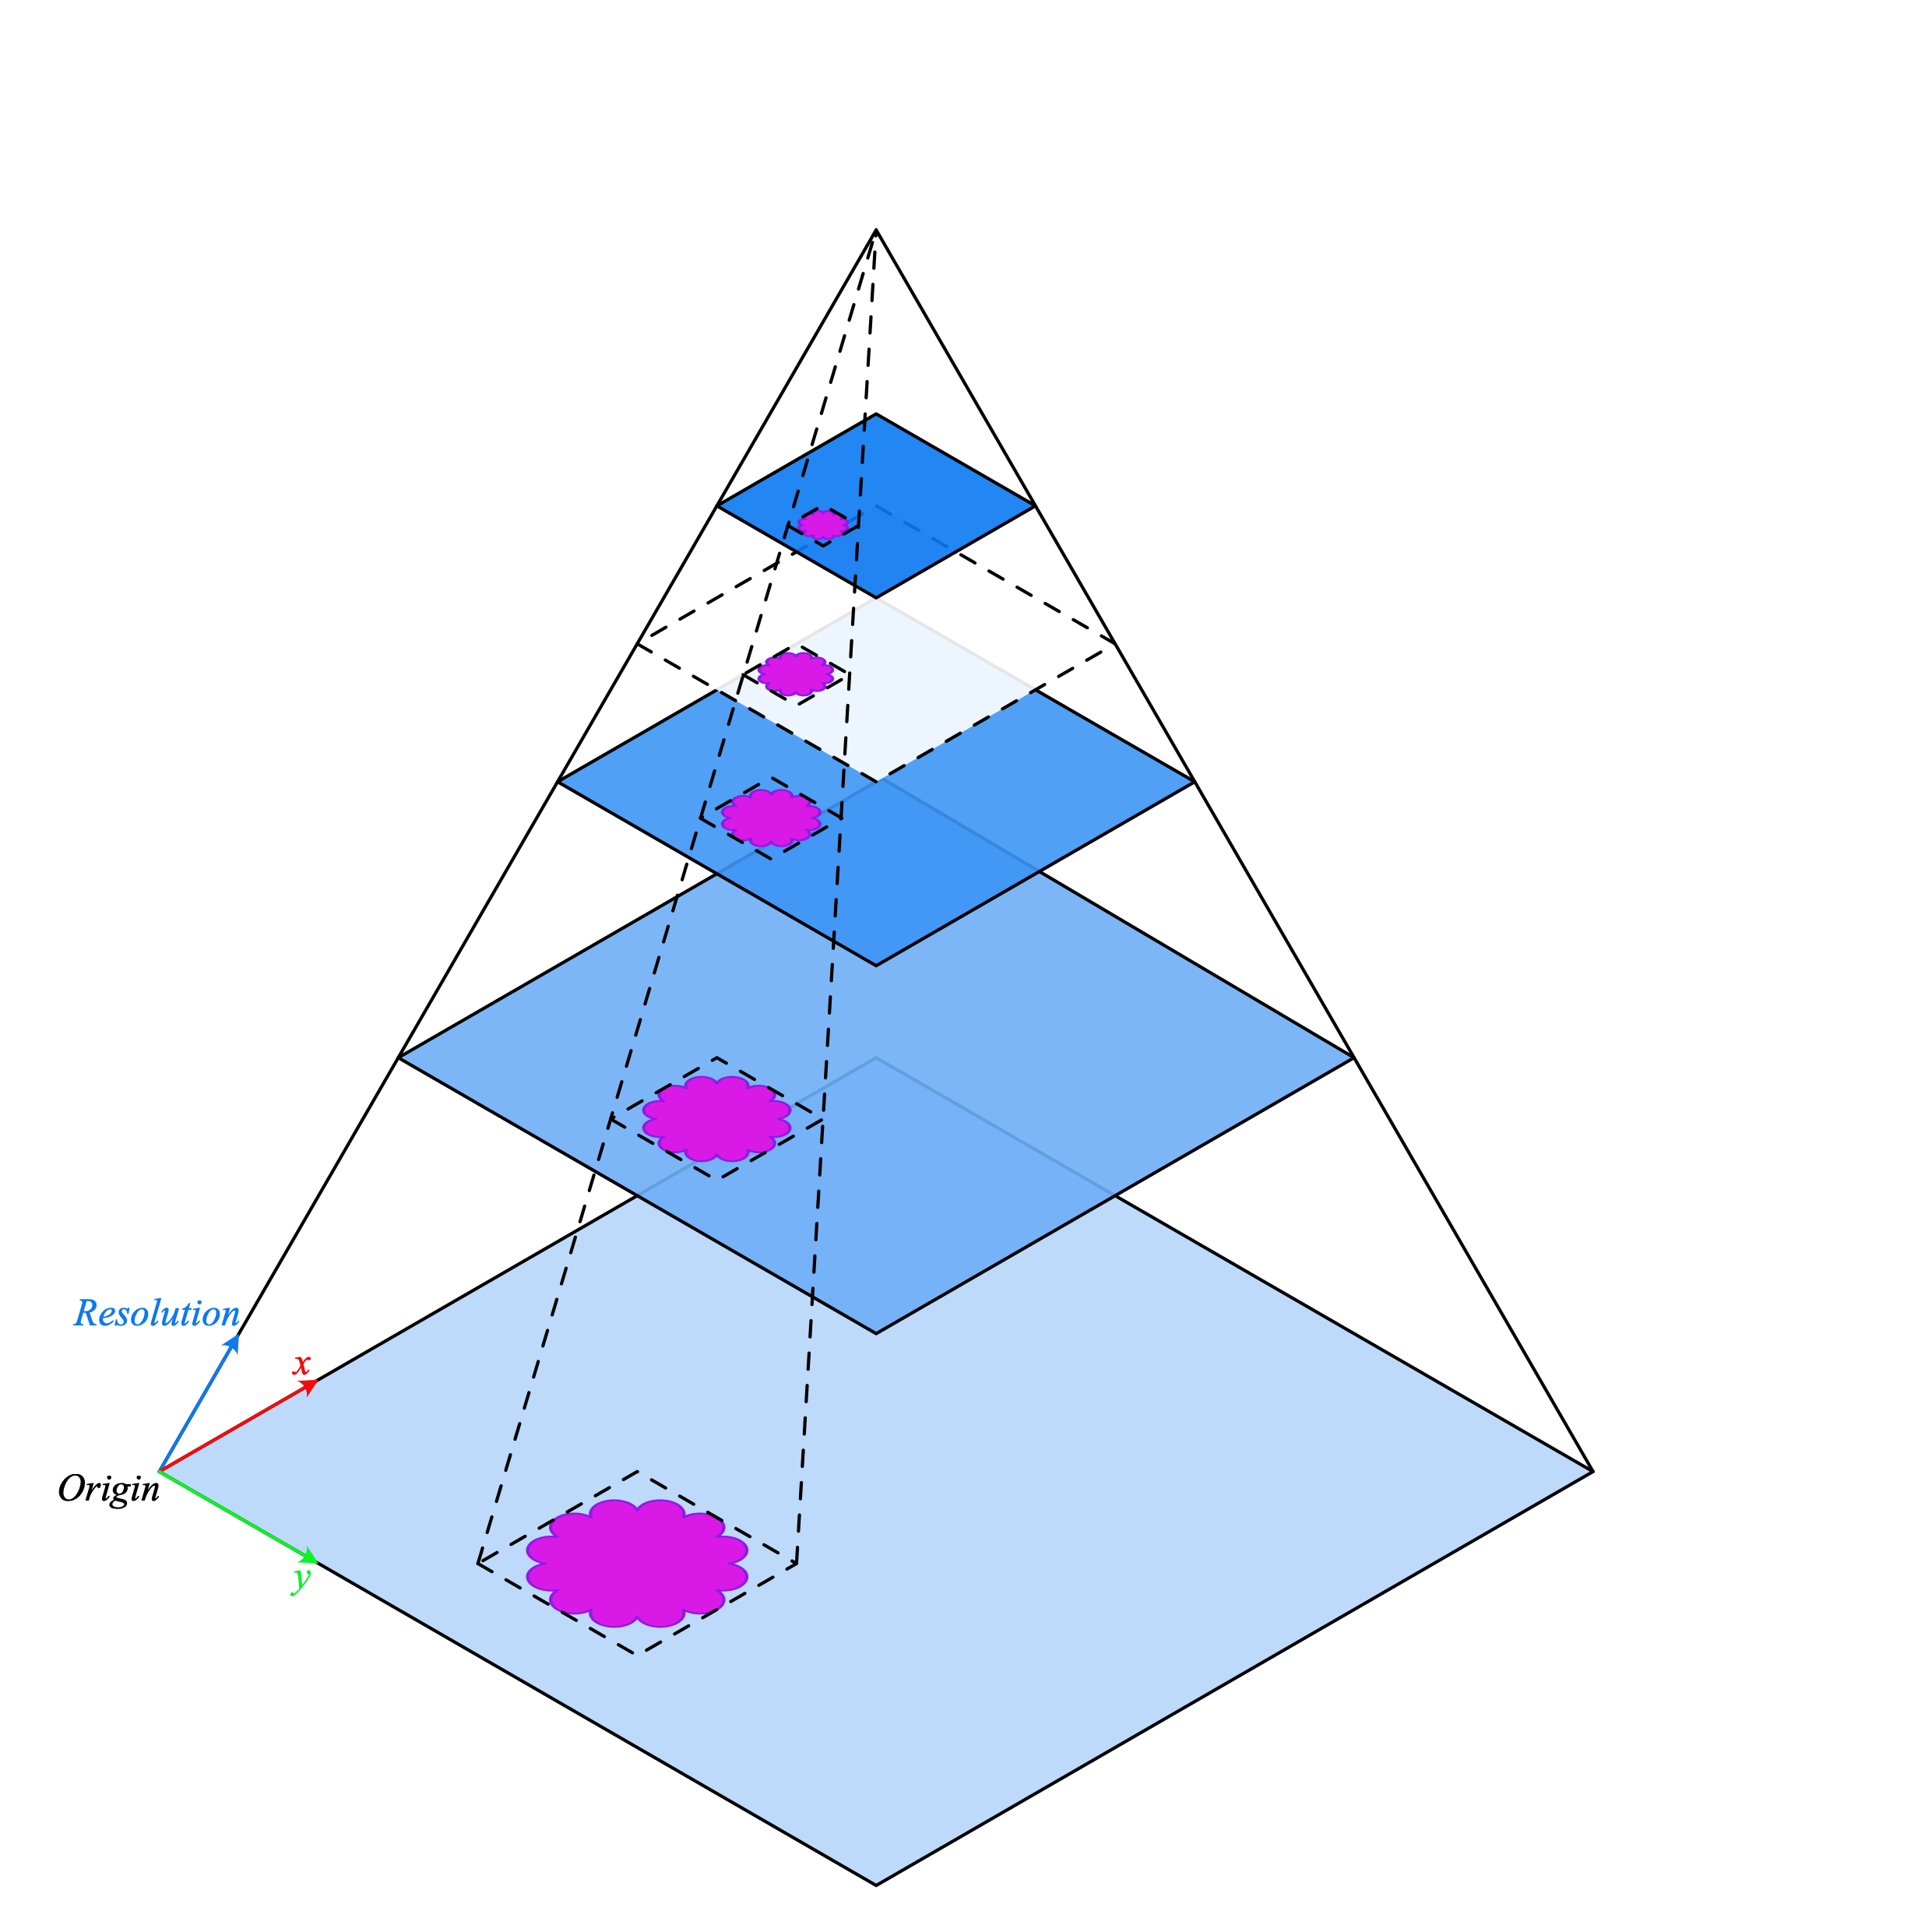

In [ ]:
'''
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install histoencoder | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."
'''

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1

In [ ]:
!pip install histoencoder | tail -n 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.
cudf-polars-cu12 25.2.2 requires polars<1.22,>=1.20, but you have polars 0.16.18 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.0.1 which is incompatible.


In [ ]:
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1

  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-o81iricl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
histoprep 2.0.5 requires pillow<10,>=9, but you have pillow 11.2.1 which is incompatible.
histoencoder 0.1.1 requires timm<0.6,>=0.5, but you have timm 1.0.15 which is incompatible.
histoencoder 0.1.1 requires torchvision<0.16,>=0.15, but you have torchvision 0.22.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
notebook 6.5.7 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.
jupyter-kernel-gateway 2.5.2 requires jupyter-client<8.0,>=5.2.0, but you have jupyter-client 8.6.3 which is i

In [ ]:
from __future__ import annotations

# 경고 메시지 필터링
import logging
import warnings
if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# 파일 다운로드랑 압축관련 모듈
import shutil
from pathlib import Path
from zipfile import ZipFile

# 데이터 처리 및 시각화 관련 모듈
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm         # 컬러맵
import PIL                        # 이미지 처리를 위함
import contextlib                 # 콘솔 출력 제어
import io
from sklearn.metrics import accuracy_score, confusion_matrix

# WSI 처리를 위한 TIAToolbox 관련 모듈
from tiatoolbox import logger
from tiatoolbox.models.architecture import vanilla
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.utils.misc import download_data, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

# PyTorch
import torch
from torchvision import transforms

# 시각화 설정 - 고해상도에 흰색배경으로
mpl.rcParams["figure.dpi"] = 160            # 고해상도 이미지
mpl.rcParams["figure.facecolor"] = "white"  # 그래프 텍스트 잘보이게

ON_GPU = True

# 많은 출력 억제용
def suppress_console_output():
    return contextlib.redirect_stderr(io.StringIO())

# Clean-up before a run

정상적이지 않은 종료로 문제가 발생하지 않게 모든 파일을 하나의 디렉토리에 저장되게끔 관리

In [ ]:
warnings.filterwarnings('ignore') # 모든 경고 메시지 무시
global_save_dir = Path('./tmp/')

# 디렉토리 삭제 함수
def rmdir(dir_path: str | Path) -> None:
  if Path(dir_path).is_dir():
    shutil.rmtree(dir_path)
    logger.info('Removing directory %s', dir_path) # 삭제 성공시 로그 출력

rmdir(global_save_dir)  # 이전 실행에 만들어진 디렉토리 삭제하고
global_save_dir.mkdir() # 새로 생성
logger.info('Creating new directory %s', global_save_dir) # 생성 성공시 로그 출력

# Downloading the data

In [ ]:
wsi_path = global_save_dir / "sample_wsi.svs"
patches_path = global_save_dir / "kather100k-validation-sample.zip"
weights_path = global_save_dir / "resnet18-kather100k.pth"

logger.info("Download has started. Please wait...")

# 암 조직 샘플 슬라이드 이미지(.svs 형식) 하나를 다운로드해 wsi_path에 저장
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_path,
)

# Kather100k 데이터셋의 validation 샘플 다운로드 및 압축 해제
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip",
    patches_path,
)
with ZipFile(patches_path, "r") as zipfile:
    zipfile.extractall(path=global_save_dir)

# ResNet18 기반 사전학습 모델 가중치 다운로드
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth",
    weights_path,
)

logger.info("Download is complete.")

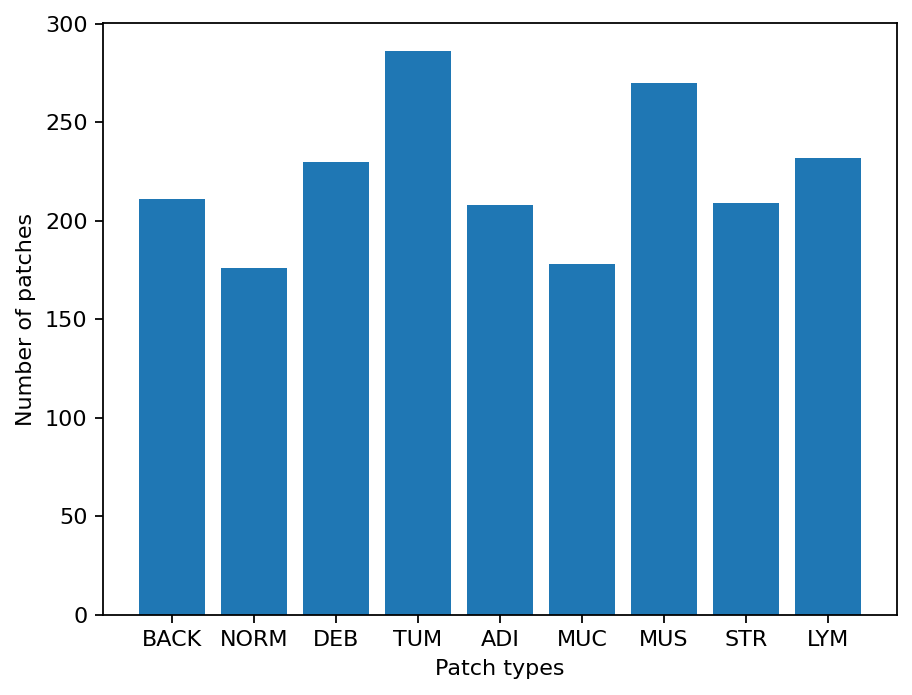

In [ ]:
datasets_path = global_save_dir / "kather100k-validation-sample"

image_ext = ".tif"

label_dict = {
    "BACK": 0, # 배경
    "NORM": 1, # 정상 대장 점막
    "DEB": 2,  # 이물질
    "TUM": 3,  # 대장선암 조직
    "ADI": 4,  # 지방 조직
    "MUC": 5,  # 점액
    "MUS": 6,  # 평활근
    "STR": 7,  # 암 관련 기질 조직
    "LYM": 8,  # 림프구
}

class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

patch_list = []
label_list = []
for class_name, label in label_dict.items():
  dataset_class_path = datasets_path / class_name
  patch_list_single_class = grab_files_from_dir(
      dataset_class_path,
      file_types="*" + image_ext,
  )
  patch_list.extend(patch_list_single_class)
  label_list.extend([label] * len(patch_list_single_class))

plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel("Patch types")
plt.ylabel("Number of patches")

for class_name, label in label_dict.items():
  logger.info(
      "Class Id: %d -- Class Name: %s -- Number of patches: %d",
      label,
      class_name,
      label_list.count(label),
  )

logger.info("Total number of patches: %d", (len(patch_list)))

# Classify image patches

patch mode를 이용해 디지털 슬라이드 내 각 이미지 패치에 대한 예측을 수행하는 방법을 먼저 볼거

In [ ]:
predictor = PatchPredictor(pretrained_model='resnet18-kather100k', batch_size=32)

model = vanilla.CNNModel(backbone="resnet18", num_classes=9)

model.load_state_dict(torch.load(weights_path, map_location="cpu", weights_only=True), strict=True)
def preproc_func(img):
  img = PIL.Image.fromarray(img)
  img = transforms.ToTensor()(img)
  return img.permute(1, 2, 0)
model.preproc_func = preproc_func
predictor = PatchPredictor(model=model, batch_size=32)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]
No GPU detected or cuda not installed, torch.compile is only supported on selected NVIDIA GPUs. Speedup numbers may be lower than expected.
No GPU detected or cuda not installed, torch.compile is only supported on selected NVIDIA GPUs. Speedup numbers may be lower than expected.


# predict patch labels

predictor를 사용해 patch_list의 이미지를 분류하고

예측 결과와 실제 라벨을 비교해서 정확도와 혼동행렬을 생성하고

이것을 DataFrame으로 변환하는 코드

In [ ]:
# patch_list에 들어 있는 이미지들을 predictor로 분류
with suppress_console_output():
    output = predictor.predict(imgs=patch_list, mode="patch")

# 실제 정답 리스트와 모델이 예측한 결과를 비교해 정확도 계산
acc = accuracy_score(label_list, output["predictions"])
logger.info("Classification accuracy: %f", acc)

# 혼동행렬 생성 후 DataFrame으로 변환
conf = confusion_matrix(label_list, output["predictions"], normalize="true")
df_cm = pd.DataFrame(conf, index=class_names, columns=class_names)
df_cm

,BACK,NORM,DEB,TUM,ADI,MUC,MUS,STR,LYM
BACK,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
NORM,0.000000,0.988636,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.00000
DEB,0.000000,0.000000,0.991304,0.000000,0.000000,0.000000,0.000000,0.008696,0.00000
TUM,0.000000,0.000000,0.000000,0.996503,0.000000,0.003497,0.000000,0.000000,0.00000
ADI,0.004808,0.000000,0.000000,0.000000,0.990385,0.000000,0.004808,0.000000,0.00000
MUC,0.000000,0.000000,0.000000,0.000000,0.000000,0.988764,0.000000,0.011236,0.00000
MUS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996296,0.003704,0.00000
STR,0.000000,0.000000,0.004785,0.000000,0.000000,0.004785,0.004785,0.985646,0.00000
LYM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004310,0.99569


# Predict patch labels for a whole slide

IOPatchPredictorConfig 클래스는 모델 예측 엔진이 사용할 이미지 읽기 및 결과 저장방식을 정의하는 설정 객체임

이 설정을 통해 분류기는 WSI 피라미드 구조에서 어떤 레벨(비율)을 사용할지 인지하고 데이터를 처리하고 예측 결과를 생성할 수 있게 됨

`input_resolutions`

- 리스트 형식의 딕셔너리 목록으로 입력 이미지의 해상도 정의

- 각 딕셔너리는 units 와 resolution 키를 포함해야됨

- 이 리스트는 모델의 forward() 함수에 전달되는 순서와 일치해야됨

- 모델의 입력이 하나면 딕셔너리 하나만 작성하면 됨

`patch_input_shape`

- 모델에 입력되는 가장 큰 패치의 크기를 나타냄

- (height, width) 형식으로 지정함

`stride_shape`

- 패치 추출 시 두 패치 사이 간격(stride)의 크기를 의미함

- (height, width) 형태로 지정

- 이 값을 patch_input_shape 과 같게 설정하면 패치들이 겹치지 않도록 연속적으로 추출

- 작게 설정할 경우 겹치는 패치들이 생기며 이는 더 세밀한 분석에 사용

In [ ]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions = [{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    stride_shape=[224, 224],
)

`predict()` 메소드는 입력 패치에 대해 CNN을 적용하여 예측결과를 생성 주요인자들은 다음과 같음

`mode` : 처리할 입력의 유형을 지정 `patch`, `tile`, `wsi` 중에 선택 (전체 슬라이드라면 wsi)

`imgs` : 처리할 이미지들의 경로 리스트로 보통 타일 이미지 경로나 WSI 파일 경로들을 담음

`return_probabilities` : `True`로 설정하면 예측된 클래스 라벨 외에 클래스별 확률분포도 함께 반환

`ioconfig` : 입력/출력 관련 설정 객체로 슬라이드에서 어떤 해상도와 어떤 패치 크기, 스트라이드 간격으로 데이터를 추출할지 저으이

`masks` : `imgs`에 대응되는 WSI의 마스크 이미지 경로 리스트로 마스크가 있다면 해당 영역만 예측 대상으로 사용

  None 이면 전체 슬라이드에서 패치 추출 및 예측 수행 -> 배경 포함 -> 불필요한 계산 가능성 있음

`merge_predictions` : Treu면 패치 예측 결과를 2D 예측 맵으로 병합해주는데 단점은 메모리를 매우많이 사용

선택적인 인자

`resolution`, `unit` : `ioconfig` 대신 직접 해상도 (level) 또는 마이크론당 픽셀 (mpp) 단위로 지정 가능

`baseline`은 일반적으로 레벨0 (가장 높은 해상도)을 의미

In [ ]:
with suppress_console_output():
  wsi_output = predictor.predict(
      imgs=[wsi_path],
      masks=None,
      mode="wsi",
      merge_predictions=False,
      ioconfig=wsi_ioconfig,
      return_probabilities=True,
      save_dir=global_save_dir / "wsi_predictions",
  )

wsi_output을 시각화함으로써 WSI에 대해 모델이 어떻게 예측을 수행했는지 확인할 수 있음 그러기 위해 패치 예측 결과들을 병합한 후 원본 이미지 위에 예측 결과를 오버레이하여 시각화 해야됨



(-0.5, 6039.5, 4703.5, -0.5)

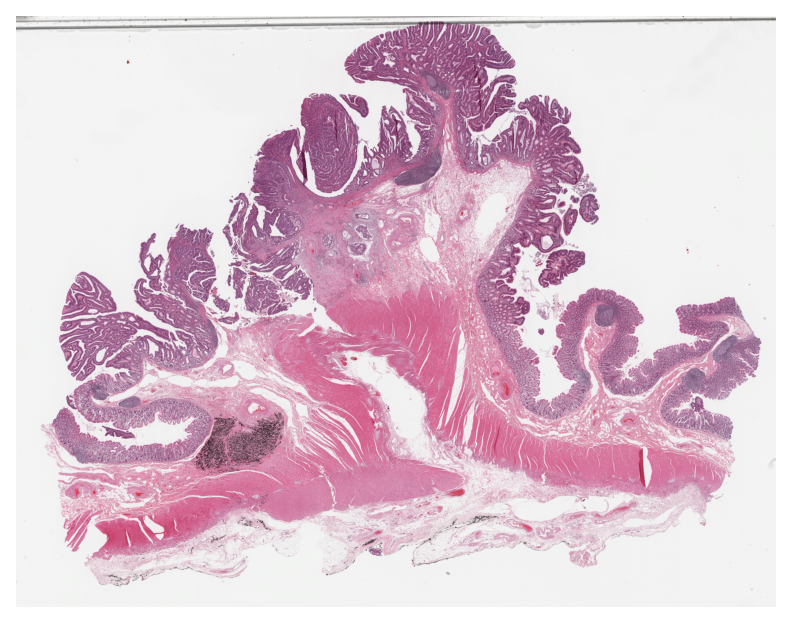

In [ ]:
# 오버레이 시 사용할 썸네일 이미지의 해상도 수준
# 4 마이크론 당 픽셀을 의미함
overview_resolution = (
    4
)

overview_unit = "mpp" # resolution 단위 지정 mpp는 마이크론 당 픽셀 의미
wsi = WSIReader.open(wsi_path) # WSIReader를 사용해 WSI 파일 열기

# WSI 이미지에서 설정한 해상도로 썸네일 이미지 추출 및 시각화
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview)
plt.axis("off")

이미지 위에 예측 맵을 오버레이 한 결과가 아래임


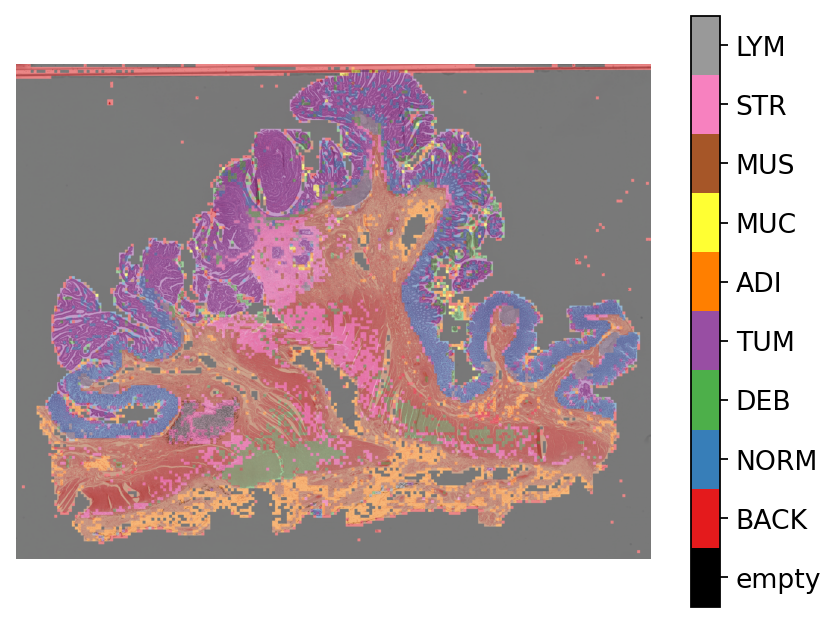

In [ ]:
label_color_dict={}
label_color_dict[0] = ("empty", (0, 0, 0,))
colors = cm.get_cmap("Set1").colors

# label_dict 에서 정의한 클래스들을 돌면서 해당 라벨에 (클래스 이름, RGB 색상)을 매핑
# label + 1을 쓰는 이유는 TIAToolbox에서 배경 = 0, 그 외는 1부터 시작하도록 처리
for class_name, label in label_dict.items():
  label_color_dict[label+1] = (class_name, 255 * np.array(colors[label]))

# 개별 패치 단위의 예측 결과들을 2차원 예측 맵으로 병합
pred_map = predictor.merge_predictions(
    wsi_path,
    wsi_output[0],
    resolution=overview_resolution,
    units=overview_unit,
)

# overlay_prediction_mask() 는 예측된 분류 결과를 컬러맵으로 그려 WSI 이미지 위에 겹침
overlay = overlay_prediction_mask(
    wsi_overview,
    pred_map,
    alpha=0.5,
    label_info=label_color_dict,
    return_ax=True,
)
plt.show()